#### Quick Analysis of the Six Degree Separation Game

In [166]:
import pandas as pd
import numpy as np
import math
from util import DegreeSeeker
from statsmodels.stats.power import tt_ind_solve_power
from imdb_scraping import df_names_1000
import seaborn as sns

In [165]:
def sample_size(population, margin_error, confidence):
    z = 1.96 # standard normal score for 95% confidence level
    p = 0.5 # proportion of the population with the characteristic of interest (assumed as 0.5 for estimation)
    e = margin_error
    n = (z**2 * p * (1-p)) / (e**2)
    return math.ceil(n)

population = 540000
confidence = 0.90
margin_error = 0.03

print("Minimum Sample Size:", sample_size(population, margin_error, confidence))

Minimum Sample Size: 1068


##### 

In [167]:
df_people = pd.read_csv('large/people.csv', sep=',')
df_people

,id,name,birth
0,1,Fred Astaire,1899.0
1,2,Lauren Bacall,1924.0
2,3,Brigitte Bardot,1934.0
3,4,John Belushi,1949.0
4,5,Ingmar Bergman,1918.0
...,...,...,...
1044494,11077515,Rosemary Sever,NaN
1044495,11077516,Sheerice,NaN
1044496,11077517,Lexie Jose,NaN
1044497,11077518,Sheerice Martinez,NaN


In [171]:
df_for_test = df_names_1000.merge(df_people, on='name', how='left')

In [186]:
df_for_test = df_for_test.loc[~df_for_test['name'].duplicated()].dropna(subset=['id']).reset_index(drop=True).copy()

In [187]:
list_for_stars = df_for_test['id'].unique().tolist()

In [188]:
df_stars = pd.read_csv('large/stars.csv', sep=',')
df_stars

,person_id,movie_id
0,844752,15724
1,869732,15724
2,194720,15724
3,650495,15724
4,8738,31458
...,...,...
1189589,9050497,9916730
1189590,10538632,9916754
1189591,3699941,9916754
1189592,9813366,9916754


In [191]:
df_stars_for_test = df_stars.loc[df_stars['person_id'].isin(list_for_stars)].reset_index(drop=True).copy()

In [192]:
dg_seeker = DegreeSeeker()

In [193]:
stars_list = df_stars_for_test['person_id'].unique().tolist()

In [197]:
dict_degree = {actor: dg_seeker.shortest_path(102, actor, df_stars_for_test, 120) for actor in stars_list}

In [198]:
df_degree = pd.DataFrame.from_dict(dict_degree, orient='index').reset_index().rename(columns={'index':'person_id', 0:'separation_degree'})

In [199]:
df_degree

,person_id,separation_degree
0,212,2
1,413168,2
2,630,2
3,1335,1
4,2024,3
...,...,...
1088,2086196,0
1089,255891,0
1090,5139,0
1091,2703058,0


<AxesSubplot:>

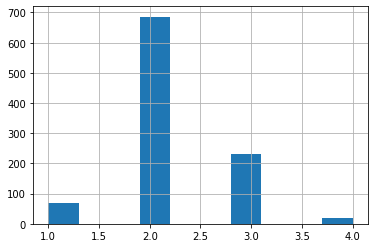

In [200]:
df_degree.loc[df_degree['separation_degree']>0]['separation_degree'].hist()

In [201]:
df_degree['separation_degree'].value_counts()

2    686
3    232
0     87
1     69
4     19
Name: separation_degree, dtype: int64

In [202]:
df_degree_without_zeros = df_degree.loc[df_degree['separation_degree']>0].reset_index(drop=True).copy()

mg_error = 1.96*(df_degree_without_zeros['separation_degree'].std())/(math.sqrt(len(stars_list))) 

In [203]:
mean = df_degree_without_zeros['separation_degree'].mean()

In [204]:
import scipy.stats as ss

ss.norm.interval(alpha=0.90, loc = mean, scale=ss.sem(df_degree_without_zeros['separation_degree']))

(2.169777988699148, 2.2298243969867366)

In [205]:
list_of_means = []

for i in range(10000):
    mean = np.random.choice(df_degree_without_zeros['separation_degree'],size = 10000, replace=True).mean()
    list_of_means.append(mean)
mean_array_from_list = np.array(list_of_means)

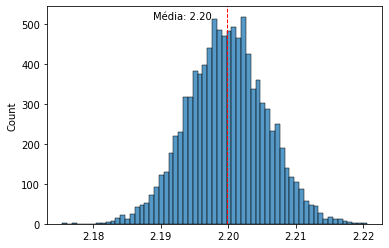

In [210]:
import matplotlib.pyplot as plt

sns.histplot(mean_array_from_list)
#sns.histplot(df_means_pos_sem_receita, kde=True)
plt.axvline(mean_array_from_list.mean(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim= plt.xlim()
plt.text(mean_array_from_list.mean()*0.995, max_ylim*230 ,'Média: {:.2f}'.format(mean_array_from_list.mean()))
plt.show()